#### Import Libraries

Credit Card Fraud Detections: Anomaly detection approach , we are going to use : Isolation Forest , One-Class SVM, Local Outlier Factor , DBSCAN

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Notice that there are not missing vlues and mistake datatypes, that is good news

#### Exploratory Data Analysis (EDA)

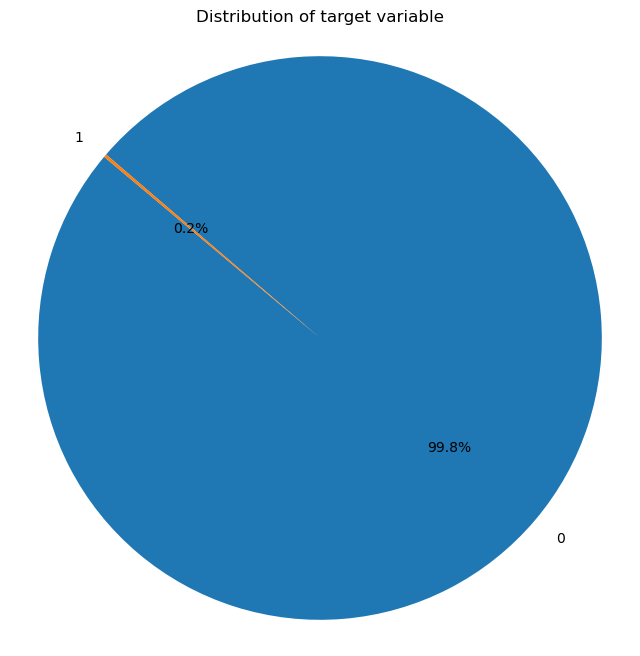

In [6]:
#Let's draw distribution of Target Variable first 
counts = df.Class.value_counts()
plt.figure(figsize=(8,8))
plt.pie(counts,labels = counts.index,autopct='%1.1f%%',startangle=140)
plt.title('Distribution of target variable')
plt.axis('equal')
plt.show()

we can see that fraudulent transactions represent only 0.2%

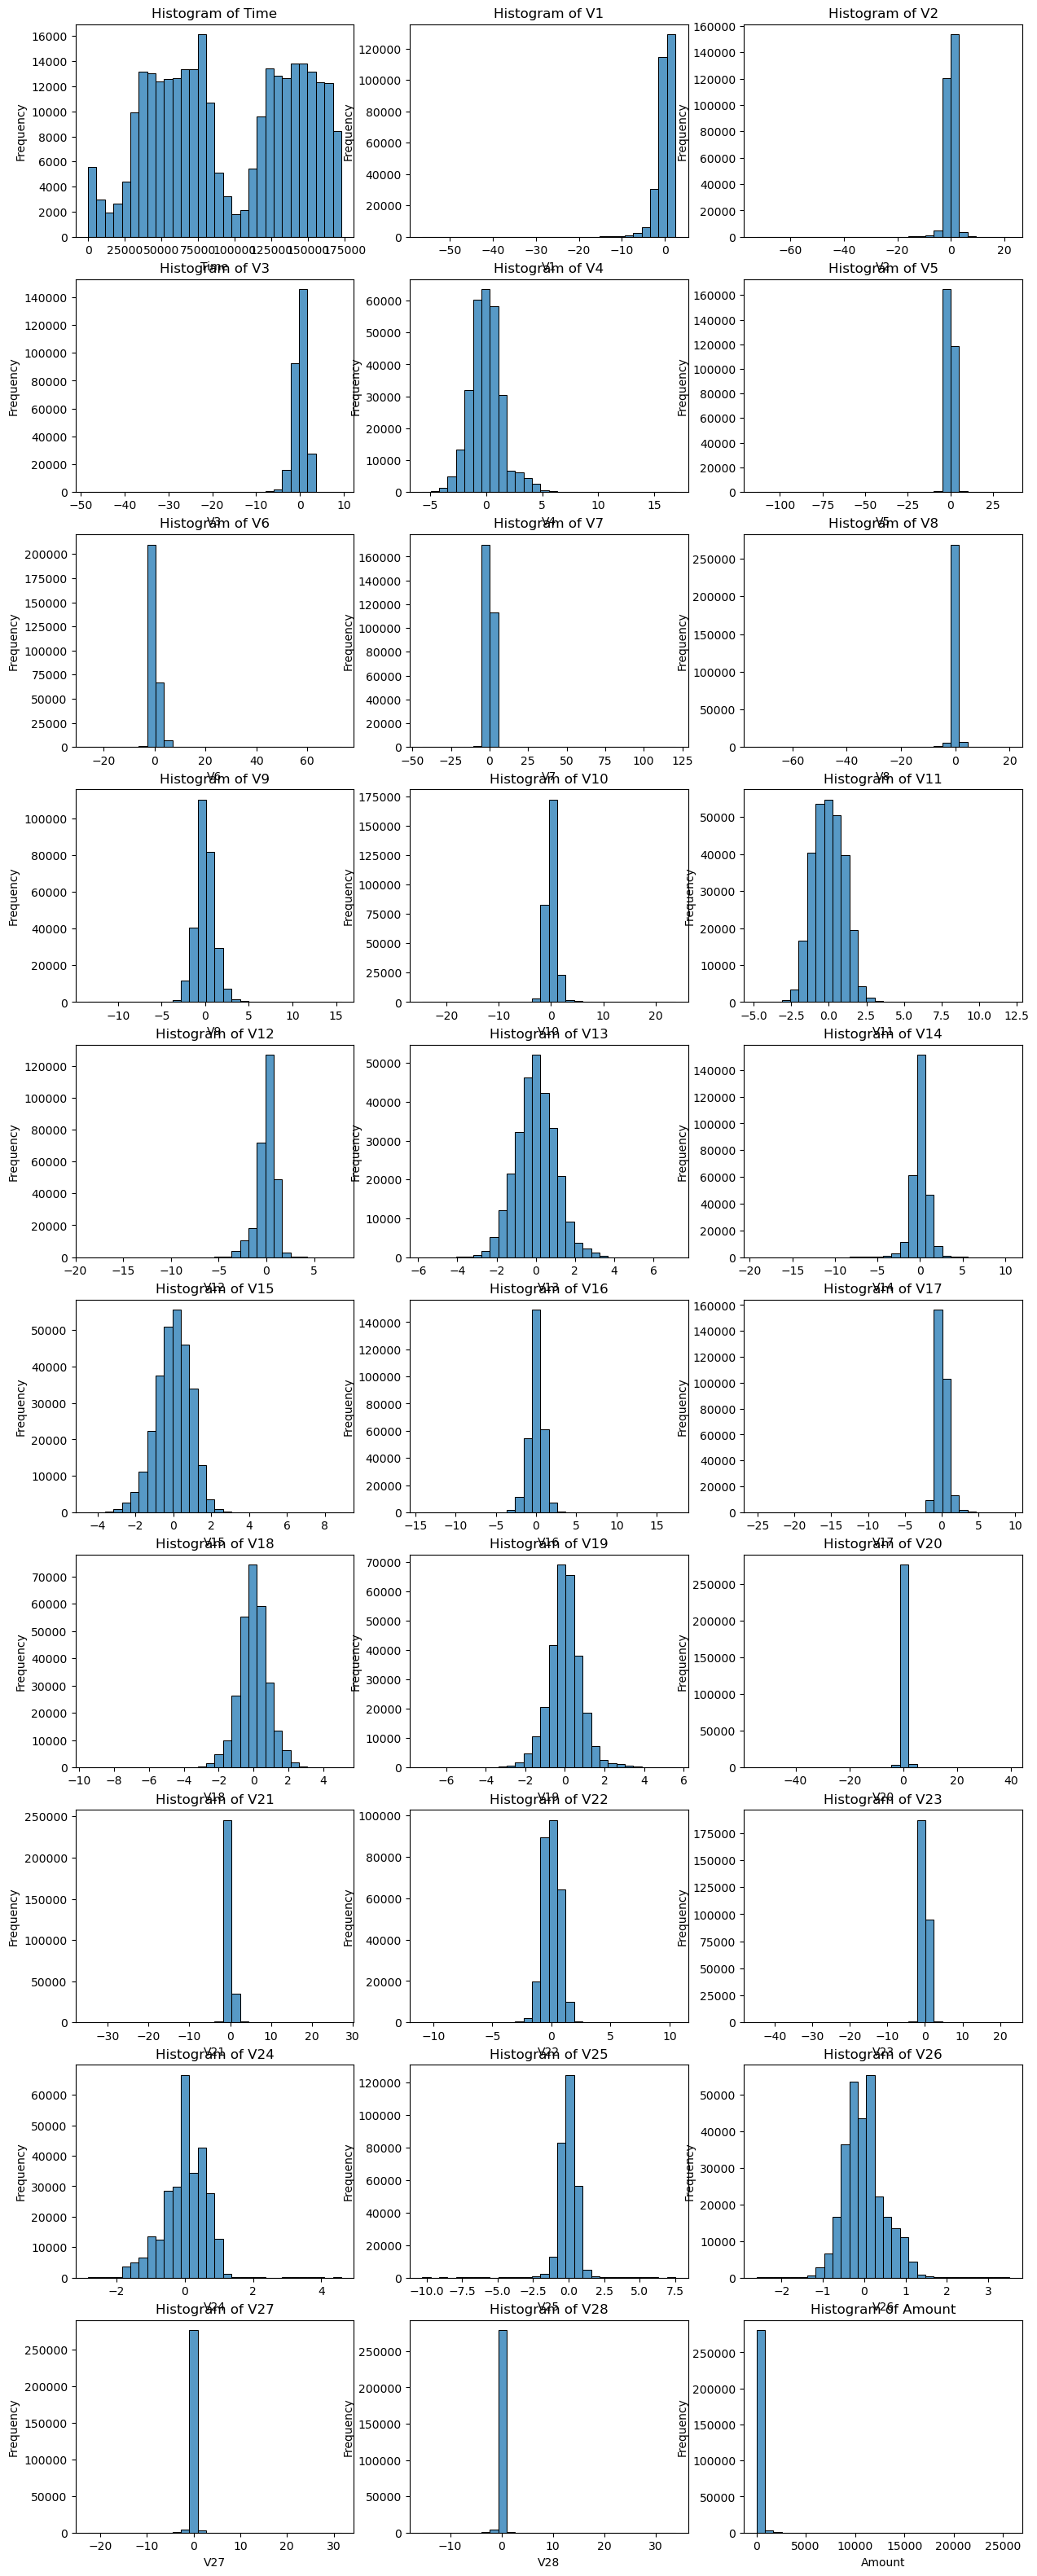

In [7]:
#Now let's draw features 
features = df.columns[:-1]
fig,axes = plt.subplots(10,3,figsize=(15,40))
axes=axes.flatten()
for i,feature in enumerate(features):
    sns.histplot(df[feature],ax=axes[i],kde=False,bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
plt.show()

We can see that there are some skewness and need to be transformed 

In [8]:
#Let's transfrom the reaming features with PCA
cols = df[['Time','Amount']]
pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)
df['V29'] = X_PCA[:,0]
df['V30'] = X_PCA[:,1]
df.drop(['Time','Amount'],axis=1,inplace=True)

#### Feature Selection 

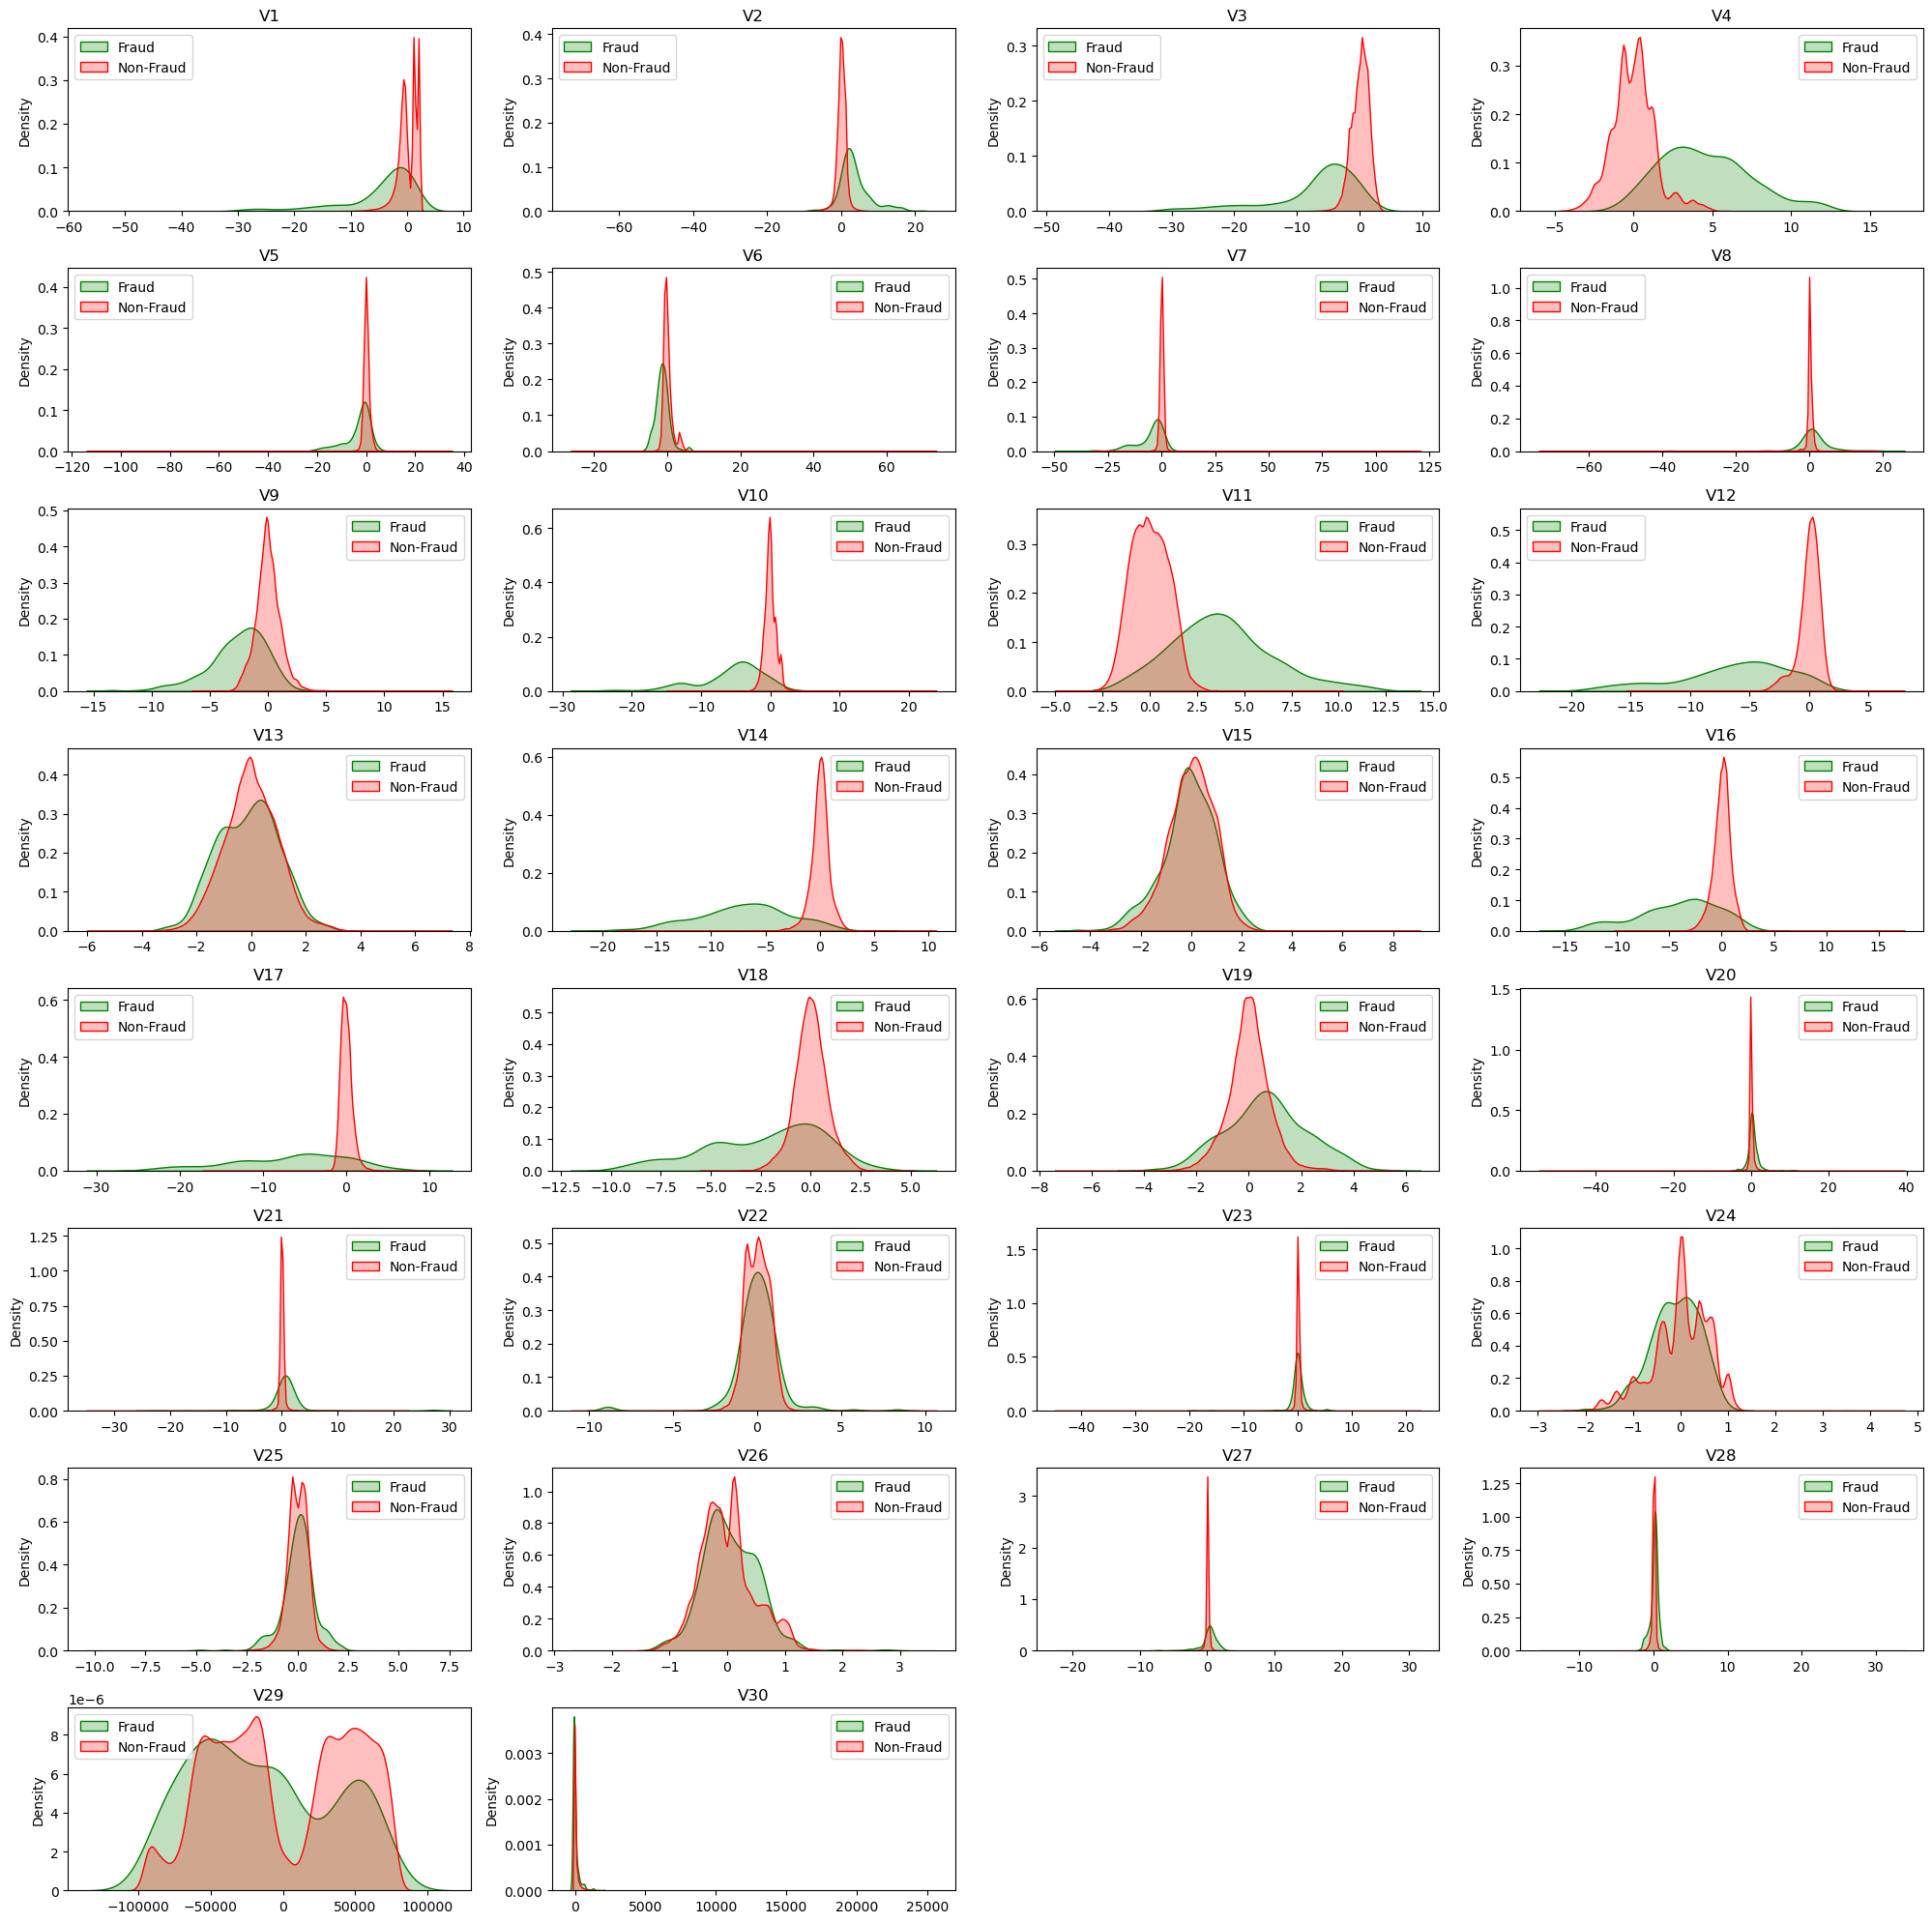

In [9]:
#Let's drop 'Class' and show Fraud and Non-Fraud
sample_columns = df.drop('Class', axis=1).columns


n_cols = 4  
n_rows = (len(sample_columns) + n_cols - 1) // n_cols  

plt.figure(figsize=(20,10*2))  

for n, col in enumerate(sample_columns, 1):
    plt.subplot(n_rows, n_cols, n)  
    sns.kdeplot(df[df['Class'] == 1][col], color='g', label='Fraud', fill=True)
    sns.kdeplot(df[df['Class'] == 0][col], color='r', label='Non-Fraud', fill=True)
    plt.ylabel('Density')
    plt.title(col)
    plt.xlabel('')
    plt.legend()


plt.tight_layout()
plt.show()

Feature Selection using Z-test: let's move to do some hypothesis testing to fing statistically significant features . We will be performing Z-test with valid transactions as our population

In [10]:
#Z-test
def ztest(feature):
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std / np.sqrt(sample_size))
    return zScore

In [11]:
columns = df.drop('Class', axis=1).columns
normal = df[df.Class == 0]
fraud = df[df.Class == 1]
sample_size = len(fraud)


significant_features = []
critical_value = 2.58  # Corresponds to a significance level of 0.01 for a two-tailed test

# Perform z-test for each feature
for feature in columns:
    z_value = ztest(feature)
    
    if abs(z_value) >= critical_value:
        print(f"{feature} is statistically significant ")
        significant_features.append(feature)
    else:
        print(f"{feature} is NOT statistically significant ")

# Summary
print("\nSignificant Features:")
print(significant_features)

V1 is statistically significant 
V2 is statistically significant 
V3 is statistically significant 
V4 is statistically significant 
V5 is statistically significant 
V6 is statistically significant 
V7 is statistically significant 
V8 is NOT statistically significant 
V9 is statistically significant 
V10 is statistically significant 
V11 is statistically significant 
V12 is statistically significant 
V13 is NOT statistically significant 
V14 is statistically significant 
V15 is NOT statistically significant 
V16 is statistically significant 
V17 is statistically significant 
V18 is statistically significant 
V19 is statistically significant 
V20 is statistically significant 
V21 is statistically significant 
V22 is NOT statistically significant 
V23 is NOT statistically significant 
V24 is statistically significant 
V25 is NOT statistically significant 
V26 is NOT statistically significant 
V27 is statistically significant 
V28 is statistically significant 
V29 is statistically signific

In [12]:
#Let's only take significant_features
significant_features.append('Class')
df = df[significant_features]


#### Feature Transformation

Let's address skewness examining our histogram plots above we can observe many of the features are highly skewed in order to tackle the issue .
We will use log transformation. As we can see that some features like V20,V25 are overlapping . Such features are not good at differentitating between normal and fraud.

In [13]:
features = df.columns[:-1]
df_transformed = df.copy()


def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed


skewness_before = df.skew()

for col in features:
    if abs(df[col].skew()) > 0.75:  
        df_transformed[col] = log_transform_skewed(df[col])


skewness_after = df_transformed.skew()

skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

skewness_comparison

,Skewness Before,Skewness After
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V9,0.554680,0.554680
V10,1.187141,0.420549
V11,0.356506,0.356506


We can see after the log transformation, the skewness is no longer there 

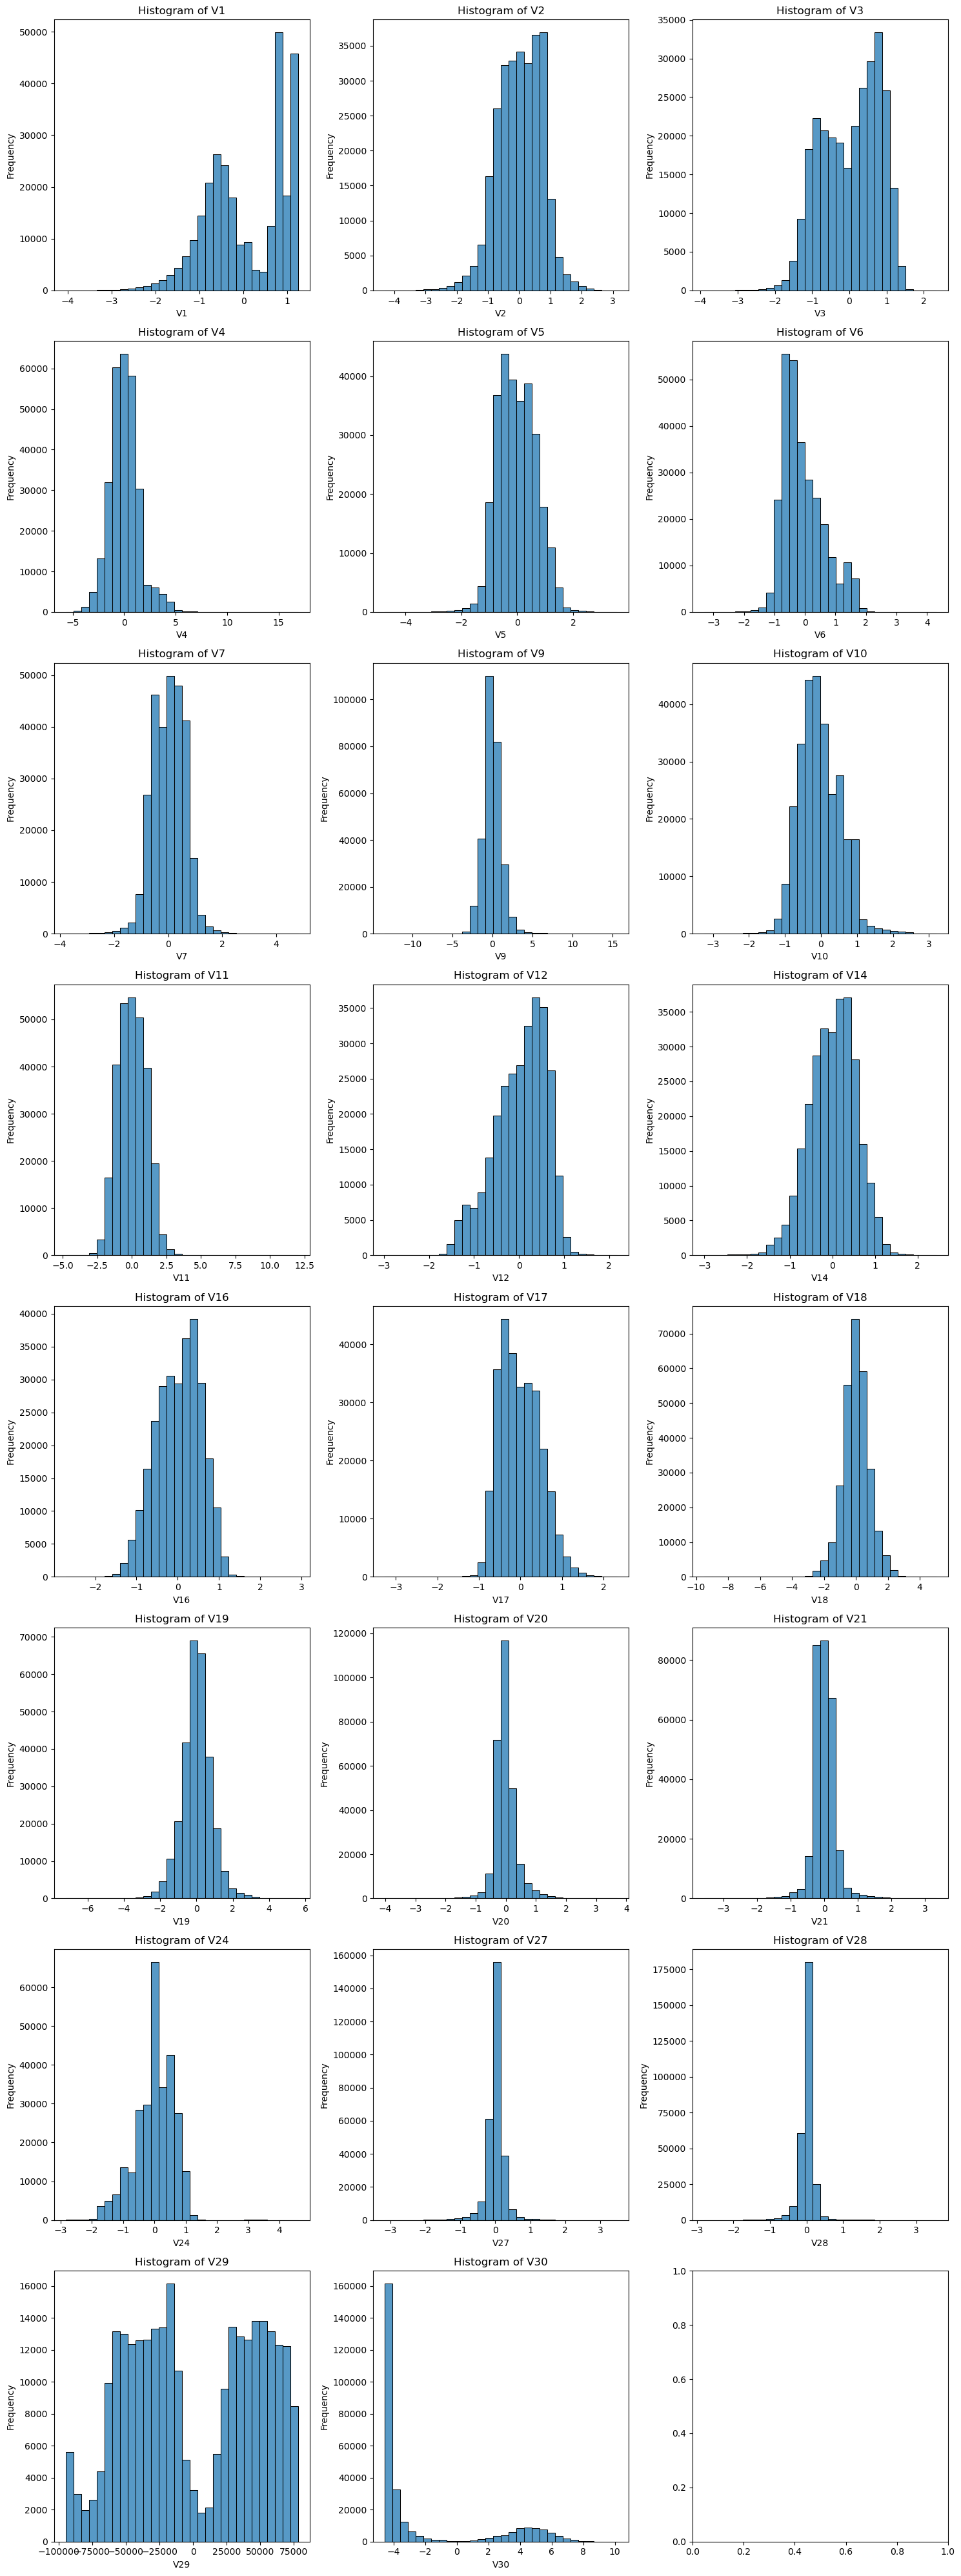

In [14]:
#Let's plot features now 
features = df.columns[:-1]
fig, axes = plt.subplots(8, 3, figsize=(15, 40))  

# Flatten axes array to loop through easily
axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Features seem ok now 

In [15]:
#Let's scale features 
X = df_transformed[features]
y = df_transformed.Class
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modelling 

#### Isolation Forest

Isolation Forest is a highly efficient and scalable technique for anomaly detection, especially in large and high-dimensional datasets, it can struggle with complex patterns thought

In [16]:
#Let's build our IsolationForest
# 1. Train the model
iso_forest = IsolationForest(contamination=0.05, random_state=111)
iso_preds = iso_forest.fit_predict(X_scaled)

# 2. Convert predictions: -1 = anomaly -> 1 (fraud), 1 = normal -> 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]




In [17]:
# Evaluate the results
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9086315933503847


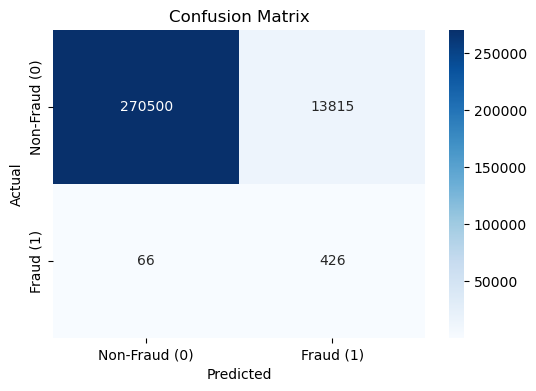

In [18]:
#Let's plot confusion matrix also 
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):

    cm = confusion_matrix(y_true, y_pred)
    

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    
    # Display the plot
    plt.show()
plot_confusion_matrix(y, iso_preds)

#### One-Class SVM

One-class SVM is a variation of the SVM model designed for anomaly detection. 

In [19]:
#Let's build our OneClassSVM model 
oc_svm = OneClassSVM(kernel='rbf',gamma = 0.001, nu=0.05)
svm_preds = oc_svm.fit_predict(X_scaled)
svm_preds = [1 if x==-1 else 0 for x in svm_preds]

In [20]:
print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)
print("Confusion Matrix:")

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.87      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.91      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9096513707385988
Confusion Matrix:


([<matplotlib.axis.YTick at 0x18704542980>,
 [Text(0, 0.5, 'Non-Fraud (0)'), Text(0, 1.5, 'Fraud (1)')])

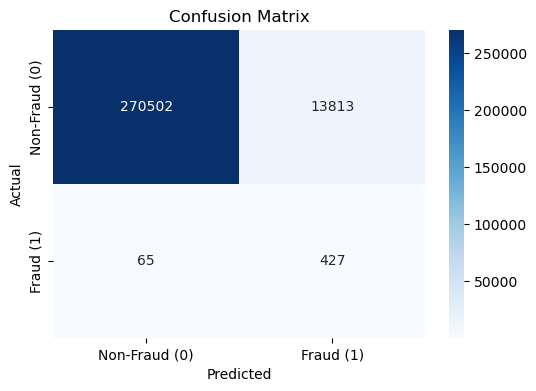

In [21]:
#Let's build confusion matrix 
cm = confusion_matrix(y, svm_preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  


plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])

#### Local Outlier Factor 

LOF is an unsupervised anomaly detection algorithm that identifies anomalies by assessing the local dnesity deviation of a data point compared its neighbors

In [27]:
#Let's build LocalOutlierFactor model
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

lof_preds = lof.fit_predict(X_scaled)
lof_preds = [1 if x == -1 else 0 for x in lof_preds]

In [26]:
# Evaluate the results
print(classification_report(y, lof_preds))
roc_auc = roc_auc_score(y, lof_preds)
print("ROC AUC Score: ", roc_auc)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.00      0.11      0.01       492

    accuracy                           0.95    284807
   macro avg       0.50      0.53      0.49    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.5309466276740744


Confusion Matrix:
[[270129  14186]
 [   437     55]]


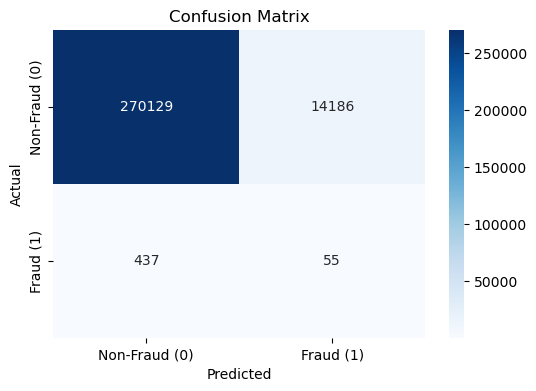

In [28]:
#Let's build confusion matrix 
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))
plot_confusion_matrix(y, lof_preds)

#### DBSCAN

DBSCAN is well-sutied for anomaly detection in datasets with irregular clusters and noise , as it can effectively isolate outlier

In [30]:
#Let's build DBSCAN 
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict (labels different clusters, outliers labeled as -1)
dbscan_preds = dbscan.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and others to 0 (non-fraud)
dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

# Evaluate the results
print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.26      0.41    284315
           1       0.00      0.92      0.00       492

    accuracy                           0.26    284807
   macro avg       0.50      0.59      0.21    284807
weighted avg       1.00      0.26      0.41    284807

ROC AUC Score:  0.5898580084582128


Confusion Matrix:
[[ 74211 210104]
 [    40    452]]


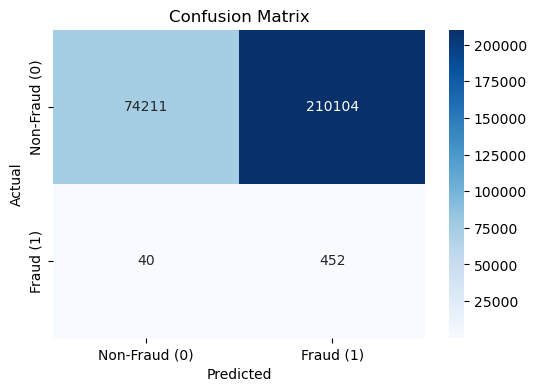

In [31]:
#Let's draw confusion matrix 
print("Confusion Matrix:")
print(confusion_matrix(y, dbscan_preds))
plot_confusion_matrix(y, dbscan_preds)

#### Conclusion 

* High recall is important for fraud detection, but it often comes at the cost of low precision.
* DBSCAN achieves exceptional recall but is impractical due to excessive false positives.
* One-Class SVM and Isolation Forest provide a better balance, making them more suitable for real-world applications.

#### Model saving 

In [34]:
import joblib
from datetime import datetime

# Timestamped version
version = datetime.now().strftime("%Y%m%d_%H%M")

# Save model, scaler, and feature list in current dir
joblib.dump(iso_forest, f"isolation_forest_{version}.pkl")
joblib.dump(scaler, f"scaler_{version}.pkl")
joblib.dump(significant_features, f"features_{version}.pkl")


['features_20250508_2214.pkl']

In [35]:
!pip freeze > requirements.txt